In [1]:
import os
import sys

main_dir = os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))))
sys.path.append(main_dir)

print("Main directory added to sys.path:", main_dir)

Main directory added to sys.path: /data/inr/llm


In [2]:
DATASET_DIR = os.path.join(
    main_dir, "Datasets","LOVEDA", "Train", "Train"
)

In [3]:
from collections import OrderedDict

COLOR_MAP_LOVEDA = OrderedDict(
    Background=(255, 255, 255),
    Building=(255, 0, 0),
    Road=(255, 255, 0),
    Water=(0, 0, 255),
    Barren=(159, 129, 183),
    Forest=(0, 255, 0),
    Agricultural=(255, 195, 128),
)

LABEL_MAP_LOVEDA = OrderedDict(
    Background=0,
    Building=1,
    Road=2,
    Water=3,
    Barren=4,
    Forest=5,
    Agricultural=6
)

In [4]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

MASK1 = os.path.join(DATASET_DIR,"Rural","masks_png", "134.png")

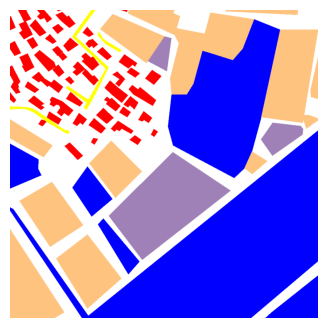

In [5]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Colors (same as you provided)
COLORS = {
    "Background": (255, 255, 255),
    "Building": (255, 0, 0),
    "Road": (255, 255, 0),
    "Water": (0, 0, 255),
    "Barren": (159, 129, 183),
    "Forest": (0, 255, 0),
    "Agricultural": (255, 195, 128),
}

def loveda_mask_to_rgb(mask_2d: np.ndarray) -> np.ndarray:
    """
    Works for:
    - Official LoveDA labels: 0=NoData(ignore), 1..7=classes
    - Reduced labels (common): 0..6=classes, 255=ignore
    """
    if mask_2d.ndim != 2:
        raise ValueError(f"Expected (H,W) mask, got shape {mask_2d.shape}")

    # LUT for 0..255
    lut = np.zeros((256, 3), dtype=np.uint8)

    # Make NO-DATA / IGNORE white
    lut[0]   = (255, 255, 255)   # official no-data
    lut[255] = (255, 255, 255)   # ignore_index variant

    u = np.unique(mask_2d)

    if u.max() <= 7:
        # Official LoveDA: background=1, building=2, ..., agriculture=7
        lut[1] = COLORS["Background"]
        lut[2] = COLORS["Building"]
        lut[3] = COLORS["Road"]
        lut[4] = COLORS["Water"]
        lut[5] = COLORS["Barren"]
        lut[6] = COLORS["Forest"]
        lut[7] = COLORS["Agricultural"]
    else:
        # Reduced labels: background=0, building=1, ..., agriculture=6; ignore often 255
        lut[0] = COLORS["Background"]
        lut[1] = COLORS["Building"]
        lut[2] = COLORS["Road"]
        lut[3] = COLORS["Water"]
        lut[4] = COLORS["Barren"]
        lut[5] = COLORS["Forest"]
        lut[6] = COLORS["Agricultural"]

    # Colorize
    return lut[mask_2d.astype(np.uint8)]

# Load mask safely as single-channel
mask_pil = Image.open(MASK1)
mask = np.array(mask_pil)
if mask.ndim == 3:
    # if someone saved it as RGB by mistake, take one channel or convert
    mask = np.array(mask_pil.convert("L"))

rgb = loveda_mask_to_rgb(mask)

plt.figure(figsize=(4, 4))
plt.imshow(rgb)
plt.axis("off")
# plt.title("LOVEDA Mask (RGB)")
plt.show()


In [6]:
from pathlib import Path
from typing import Dict, Tuple, Iterable, Optional
import numpy as np
from PIL import Image

try:
    import pandas as pd
except Exception:
    pd = None


def _iter_mask_files(mask_dir: Path) -> Iterable[Path]:
    # LoveDA usually stores masks in: <split>/<Rural|Urban>/masks_png/*.png
    # but we also support nested layouts by searching recursively.
    if not mask_dir.exists():
        return []
    direct = sorted(mask_dir.glob("*.png"))
    if len(direct) > 0:
        return direct
    return sorted(mask_dir.rglob("*.png"))


def _load_mask_as_2d(path: Path) -> np.ndarray:
    m = Image.open(path)
    arr = np.array(m)
    if arr.ndim == 2:
        return arr
    # If someone saved it as RGB/RGBA, convert to single-channel labels
    return np.array(m.convert("L"))


def _detect_loveda_convention(hist: np.ndarray) -> str:
    """Detect LoveDA label convention from a 256-bin histogram.

    Returns: "official" or "reduced"
      - official: 0=NoData(ignore), 1..7=classes
      - reduced: 0..6=classes, 255=ignore_index (common)

    Note: Presence of 255 should NOT imply official (it usually implies reduced).
    """
    if hist.shape[0] != 256:
        raise ValueError("Expected 256-bin histogram")

    has_255 = hist[255] > 0
    has_7 = hist[7] > 0
    max_nonzero = int(np.max(np.nonzero(hist)[0])) if hist.sum() > 0 else 0

    # Strong signals first
    if has_255 and not has_7:
        return "reduced"
    if has_7 and not has_255:
        return "official"
    if max_nonzero <= 6:
        return "reduced"
    if max_nonzero == 7:
        return "official"

    # Ambiguous / unexpected labels: fall back to reduced if 255 present, else official
    return "reduced" if has_255 else "official"


def compute_class_percentages_for_dir(
    mask_dir: Path,
    *,
    reduced_names: Optional[Tuple[str, ...]] = None,
    official_names: Optional[Tuple[str, ...]] = None,
    ignore_reduced: Tuple[int, ...] = (255,),
    ignore_official: Tuple[int, ...] = (0,),
    max_masks: Optional[int] = None,
    return_num_masks: bool = False,
    return_valid_pixels: bool = False,
):
    """
    Returns by default:
      - percentages: {class_name: percent_of_valid_pixels}
      - counts: {class_name: raw_pixel_count}

    Optionally also returns:
      - num_masks: number of mask images aggregated
      - valid_pixels: total valid pixels (after ignoring convention's ignore index)

    Automatically detects whether masks are in "official" (1..7 + 0=NoData)
    or "reduced" (0..6 + 255=ignore) label convention.
    """
    # Defaults aligned with your COLOR/LABEL map ordering
    if reduced_names is None:
        reduced_names = (
            "Background", "Building", "Road", "Water", "Barren", "Forest", "Agricultural"
        )
    if official_names is None:
        official_names = (
            "Background", "Building", "Road", "Water", "Barren", "Forest", "Agricultural"
        )

    files = list(_iter_mask_files(mask_dir))
    if max_masks is not None:
        files = files[:max_masks]
    if len(files) == 0:
        raise FileNotFoundError(f"No .png masks found under: {mask_dir}")

    hist = np.zeros(256, dtype=np.int64)
    for p in files:
        mask = _load_mask_as_2d(p)
        # Robust bincount over uint8 range
        m = mask.astype(np.uint8, copy=False).ravel()
        hist += np.bincount(m, minlength=256)

    # Detect convention (robust to ignore=255)
    convention = _detect_loveda_convention(hist)
    if convention == "official":
        class_ids = list(range(1, 8))
        class_names = official_names
        ignore_vals = set(ignore_official)
    else:
        class_ids = list(range(0, 7))
        class_names = reduced_names
        ignore_vals = set(ignore_reduced)

    # Build valid pixel total (exclude ignore indices for the chosen convention)
    total_pixels = int(hist.sum())
    ignore_pixels = int(sum(hist[v] for v in ignore_vals if 0 <= v <= 255))
    valid_pixels = total_pixels - ignore_pixels
    if valid_pixels <= 0:
        raise ValueError(f"No valid pixels after ignoring {sorted(ignore_vals)} in {mask_dir}")

    counts: Dict[str, int] = {}
    percentages: Dict[str, float] = {}
    for cid, cname in zip(class_ids, class_names):
        c = int(hist[cid])
        counts[cname] = c
        percentages[cname] = 100.0 * (c / valid_pixels)

    out = [percentages, counts]
    if return_num_masks:
        out.append(len(files))
    if return_valid_pixels:
        out.append(valid_pixels)
    return tuple(out) if len(out) > 2 else (percentages, counts)


def summarize_rural_urban_percentages(dataset_dir: str) -> None:
    base = Path(dataset_dir)
    rural_dir = base / "Rural" / "masks_png"
    urban_dir = base / "Urban" / "masks_png"

    rural_pct, rural_counts = compute_class_percentages_for_dir(rural_dir)
    urban_pct, urban_counts = compute_class_percentages_for_dir(urban_dir)

    # Pretty output
    rows = []
    for name in rural_pct.keys():
        rows.append(
            {
                "Class": name,
                "Rural_%": rural_pct[name],
                "Urban_%": urban_pct.get(name, float("nan")),
                "Rural_pixels": rural_counts[name],
                "Urban_pixels": urban_counts.get(name, 0),
            }
        )

    if pd is not None:
        df = pd.DataFrame(rows)
        df["Rural_%"] = df["Rural_%"].map(lambda x: round(float(x), 4))
        df["Urban_%"] = df["Urban_%"].map(lambda x: round(float(x), 4))
        display(df)
    else:
        # Fallback if pandas isn't installed
        for r in rows:
            print(
                f"{r['Class']:<14} | Rural: {r['Rural_%']:.4f}% ({r['Rural_pixels']})"
                f" | Urban: {r['Urban_%']:.4f}% ({r['Urban_pixels']})"
            )


summarize_rural_urban_percentages(DATASET_DIR)

,Class,Rural_%,Urban_%,Rural_pixels,Urban_pixels
0,Background,25.2821,48.4507,351704076,559004254
1,Building,2.6519,21.2004,36891628,244601897
2,Road,1.9448,9.2797,27053972,107065867
3,Water,8.6028,3.7317,119674656,43055087
4,Barren,3.2679,7.5656,45460577,87288280
5,Forest,22.8403,7.9167,317735062,91339922
6,Agricultural,35.4102,1.8551,492598197,21403138


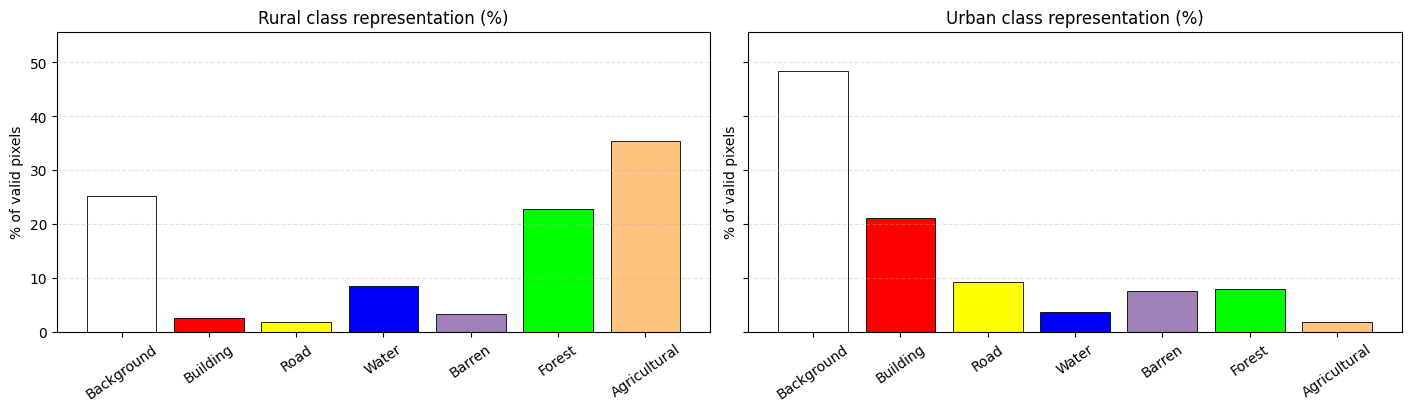

In [7]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# Two bar charts (Rural vs Urban) showing class representation (%) with LoveDA colors.
base = Path(DATASET_DIR)
rural_dir = base / "Rural" / "masks_png"
urban_dir = base / "Urban" / "masks_png"

rural_pct, _ = compute_class_percentages_for_dir(rural_dir)
urban_pct, _ = compute_class_percentages_for_dir(urban_dir)

class_names = list(rural_pct.keys())
rural_vals = [rural_pct[c] for c in class_names]
urban_vals = [urban_pct.get(c, 0.0) for c in class_names]

# Use your defined class colors; fall back to gray if missing
bar_colors = [np.array(COLORS.get(c, (160, 160, 160))) / 255.0 for c in class_names]

fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True, constrained_layout=True)

for ax, title, vals in zip(
    axes,
    ["Rural class representation (%)", "Urban class representation (%)"],
    [rural_vals, urban_vals],
):
    ax.bar(class_names, vals, color=bar_colors, edgecolor="black", linewidth=0.6)
    ax.set_title(title)
    ax.set_ylabel("% of valid pixels")
    ax.set_ylim(0, max(max(rural_vals), max(urban_vals)) * 1.15)
    ax.grid(axis="y", linestyle="--", alpha=0.35)
    ax.tick_params(axis="x", rotation=35)

plt.show()

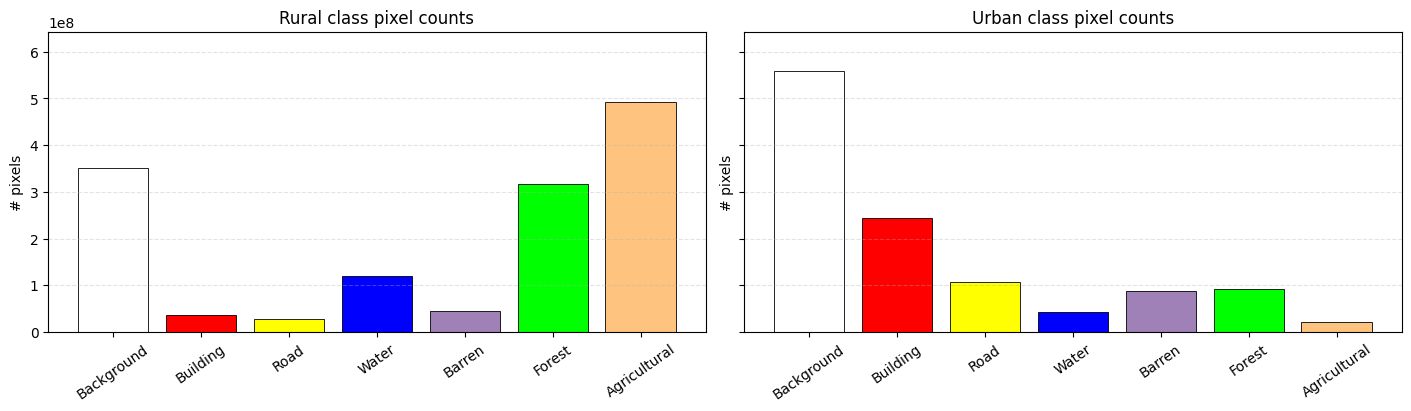

In [8]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# Two bar charts (Rural vs Urban) showing RAW pixel counts per class with LoveDA colors.
# Reuses: DATASET_DIR, COLORS, compute_class_percentages_for_dir() from prior cells.

base = Path(DATASET_DIR)
rural_dir = base / "Rural" / "masks_png"
urban_dir = base / "Urban" / "masks_png"

_, rural_counts = compute_class_percentages_for_dir(rural_dir)
_, urban_counts = compute_class_percentages_for_dir(urban_dir)

class_names = list(rural_counts.keys())
rural_vals = [rural_counts[c] for c in class_names]
urban_vals = [urban_counts.get(c, 0) for c in class_names]

# Use your defined class colors; fall back to gray if missing
bar_colors = [np.array(COLORS.get(c, (160, 160, 160))) / 255.0 for c in class_names]

fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True, constrained_layout=True)

for ax, title, vals in zip(
    axes,
    ["Rural class pixel counts", "Urban class pixel counts"],
    [rural_vals, urban_vals],
):
    ax.bar(class_names, vals, color=bar_colors, edgecolor="black", linewidth=0.6)
    ax.set_title(title)
    ax.set_ylabel("# pixels")
    ax.set_ylim(0, max(max(rural_vals), max(urban_vals)) * 1.15)
    ax.grid(axis="y", linestyle="--", alpha=0.35)
    ax.tick_params(axis="x", rotation=35)

plt.show()

/data/inr/llm/Datasets/LOVEDA/Train/Train
1366 Rural images
1156 Urban images


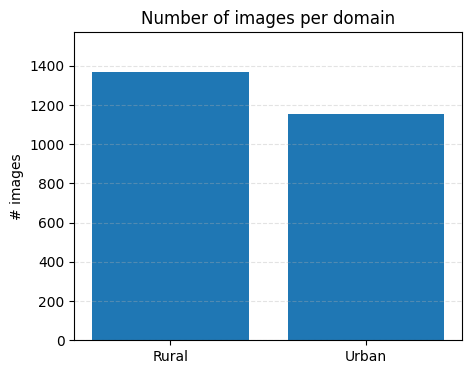

In [11]:
from pathlib import Path
import matplotlib.pyplot as plt

def count_domain_images(domain_root: Path) -> int:
    """Count image files for a domain (Rural/Urban) with a few common folder conventions."""
    candidates = [
        domain_root / "images_png",
        domain_root / "images",
        domain_root / "imgs",
        domain_root / "img",
    ]
    exts = {".png", ".jpg", ".jpeg", ".tif", ".tiff"}

    for d in candidates:
        if d.exists():
            return sum(1 for p in d.iterdir() if p.is_file() and p.suffix.lower() in exts)

    # Fallback: search recursively but avoid masks folders
    count = 0
    for p in domain_root.rglob("*"):
        if not p.is_file():
            continue
        if p.suffix.lower() not in exts:
            continue
        parts = {s.lower() for s in p.parts}
        if "masks" in parts or "masks_png" in parts or "mask" in parts:
            continue
        count += 1
    return count

DATASET_DIR2 = os.path.join(
    DATASET_DIR, "../../Train/Train"
)
print(os.path.abspath(DATASET_DIR))

base = Path(DATASET_DIR)
rural_root = base / "Rural"
urban_root = base / "Urban"

rural_n = count_domain_images(rural_root)
urban_n = count_domain_images(urban_root)

print(rural_n, "Rural images")
print(urban_n, "Urban images")

plt.figure(figsize=(5, 4))
plt.bar(["Rural", "Urban"], [rural_n, urban_n])
plt.title("Number of images per domain")
plt.ylabel("# images")
plt.ylim(0, max(rural_n, urban_n) * 1.15 if max(rural_n, urban_n) > 0 else 1)
plt.grid(axis="y", linestyle="--", alpha=0.35)
plt.show()

In [10]:
from pathlib import Path

# Average pixels per image, per class (Rural vs Urban) for Train masks.
base = Path(DATASET_DIR)
rural_dir = base / "Rural" / "masks_png"
urban_dir = base / "Urban" / "masks_png"

# Reuse the aggregator, but also get number of masks aggregated
rural_pct, rural_counts, rural_num = compute_class_percentages_for_dir(rural_dir, return_num_masks=True)
urban_pct, urban_counts, urban_num = compute_class_percentages_for_dir(urban_dir, return_num_masks=True)

rows = []
for cls in rural_counts.keys():
    rows.append({
        "Class": cls,
        "Rural_avg_pixels_per_image": rural_counts[cls] / max(rural_num, 1),
        "Urban_avg_pixels_per_image": urban_counts.get(cls, 0) / max(urban_num, 1),
        "Rural_num_masks": rural_num,
        "Urban_num_masks": urban_num,
    })

if pd is not None:
    df_avg = pd.DataFrame(rows)
    # nicer display
    df_avg["Rural_avg_pixels_per_image"] = df_avg["Rural_avg_pixels_per_image"].map(lambda x: round(float(x), 2))
    df_avg["Urban_avg_pixels_per_image"] = df_avg["Urban_avg_pixels_per_image"].map(lambda x: round(float(x), 2))
    display(df_avg)
else:
    for r in rows:
        print(
            f"{r['Class']:<14} | Rural avg px/img: {r['Rural_avg_pixels_per_image']:.2f} "
            f"(n={r['Rural_num_masks']}) | Urban avg px/img: {r['Urban_avg_pixels_per_image']:.2f} (n={r['Urban_num_masks']})"
        )

KeyboardInterrupt: 

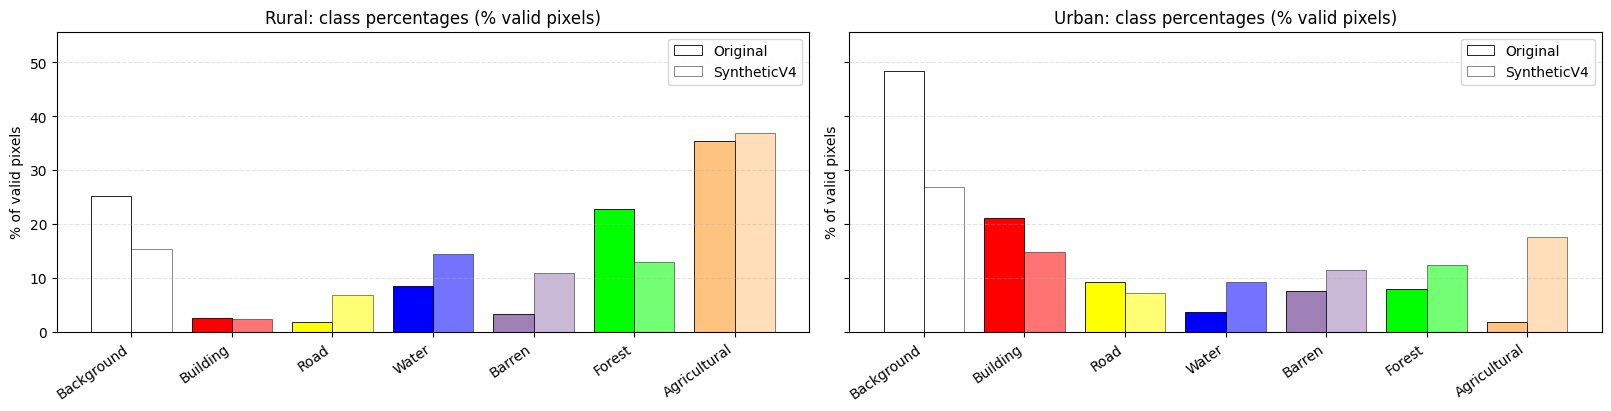

In [ ]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# Synthetic V4 dataset root
SYNTHETIC_DATASET_DIR = "/data/inr/llm/DIFF_CD/Diffusor/SyntheticDatasetFINAL/Train/Train"

def compute_domain_percentages_from_mask_dirs(
    mask_dirs,
    *,
    reduced_names=None,
    official_names=None,
    ignore_reduced=(255,),
    ignore_official=(0,),
    max_masks=None,
 ):
    """Compute per-class percentages/counts for a domain across one or more mask directories.

    Aggregates all masks first, then detects LoveDA convention once, and computes
    percentages over valid pixels (ignoring the convention's ignore index).
    """
    if reduced_names is None:
        reduced_names = (
            "Background", "Building", "Road", "Water", "Barren", "Forest", "Agricultural"
        )
    if official_names is None:
        official_names = (
            "Background", "Building", "Road", "Water", "Barren", "Forest", "Agricultural"
        )

    # Collect files from all dirs
    files = []
    for d in mask_dirs:
        d = Path(d)
        if not d.exists():
            raise FileNotFoundError(f"Mask directory not found: {d}")
        files.extend(list(_iter_mask_files(d)))
    files = sorted(files)
    if max_masks is not None:
        files = files[:max_masks]
    if len(files) == 0:
        raise FileNotFoundError(f"No .png masks found under: {mask_dirs}")

    hist = np.zeros(256, dtype=np.int64)
    for p in files:
        mask = _load_mask_as_2d(p)
        m = mask.astype(np.uint8, copy=False).ravel()
        hist += np.bincount(m, minlength=256)

    convention = _detect_loveda_convention(hist)
    if convention == "official":
        class_ids = list(range(1, 8))
        class_names = official_names
        ignore_vals = set(ignore_official)
    else:
        class_ids = list(range(0, 7))
        class_names = reduced_names
        ignore_vals = set(ignore_reduced)

    total_pixels = int(hist.sum())
    ignore_pixels = int(sum(hist[v] for v in ignore_vals if 0 <= v <= 255))
    valid_pixels = total_pixels - ignore_pixels
    if valid_pixels <= 0:
        raise ValueError(f"No valid pixels after ignoring {sorted(ignore_vals)} in {mask_dirs}")

    counts = {}
    percentages = {}
    for cid, cname in zip(class_ids, class_names):
        c = int(hist[cid])
        counts[cname] = c
        percentages[cname] = 100.0 * (c / valid_pixels)

    return percentages, counts, convention, valid_pixels

# Build mask dirs for each split/domain
orig_base = Path(DATASET_DIR)
syn_base = Path(SYNTHETIC_DATASET_DIR)

orig_rural_dir = orig_base / "Rural" / "masks_png"
orig_urban_dir = orig_base / "Urban" / "masks_png"
syn_rural_dir = syn_base / "Rural" / "masks_png"
syn_urban_dir = syn_base / "Urban" / "masks_png"

# Percentages for Original vs SyntheticV4, separately for Rural and Urban
orig_rural_pct, _, rural_conv_o, _ = compute_domain_percentages_from_mask_dirs([orig_rural_dir])
syn_rural_pct, _, rural_conv_s, _ = compute_domain_percentages_from_mask_dirs([syn_rural_dir])

orig_urban_pct, _, urban_conv_o, _ = compute_domain_percentages_from_mask_dirs([orig_urban_dir])
syn_urban_pct, _, urban_conv_s, _ = compute_domain_percentages_from_mask_dirs([syn_urban_dir])

# Optional sanity check: conventions should match
if rural_conv_o != rural_conv_s:
    print(f"Warning: Rural convention differs (orig={rural_conv_o}, syn={rural_conv_s})")
if urban_conv_o != urban_conv_s:
    print(f"Warning: Urban convention differs (orig={urban_conv_o}, syn={urban_conv_s})")

class_names = list(orig_rural_pct.keys())
bar_colors = [np.array(COLORS.get(c, (160, 160, 160))) / 255.0 for c in class_names]
x = np.arange(len(class_names))
w = 0.40

fig, axes = plt.subplots(1, 2, figsize=(16, 4), sharey=True, constrained_layout=True)

# Rural subplot (percentages)
rural_orig_vals = [orig_rural_pct[c] for c in class_names]
rural_syn_vals = [syn_rural_pct.get(c, 0.0) for c in class_names]
axes[0].bar(x - w/2, rural_orig_vals, width=w, color=bar_colors, edgecolor="black", linewidth=0.6, label="Original")
axes[0].bar(x + w/2, rural_syn_vals, width=w, color=bar_colors, edgecolor="black", linewidth=0.6, alpha=0.55, label="SyntheticV4")
axes[0].set_title("Rural: class percentages (% valid pixels)")
axes[0].set_xticks(x)
axes[0].set_xticklabels(class_names, rotation=35, ha="right")
axes[0].set_ylabel("% of valid pixels")
axes[0].set_ylim(0, max(max(rural_orig_vals), max(rural_syn_vals)) * 1.15)
axes[0].grid(axis="y", linestyle="--", alpha=0.35)
axes[0].legend()

# Urban subplot (percentages)
urban_orig_vals = [orig_urban_pct[c] for c in class_names]
urban_syn_vals = [syn_urban_pct.get(c, 0.0) for c in class_names]
axes[1].bar(x - w/2, urban_orig_vals, width=w, color=bar_colors, edgecolor="black", linewidth=0.6, label="Original")
axes[1].bar(x + w/2, urban_syn_vals, width=w, color=bar_colors, edgecolor="black", linewidth=0.6, alpha=0.55, label="SyntheticV4")
axes[1].set_title("Urban: class percentages (% valid pixels)")
axes[1].set_xticks(x)
axes[1].set_xticklabels(class_names, rotation=35, ha="right")
axes[1].set_ylabel("% of valid pixels")
axes[1].set_ylim(0, max(max(urban_orig_vals), max(urban_syn_vals)) * 1.15)
axes[1].grid(axis="y", linestyle="--", alpha=0.35)
axes[1].legend()

plt.show()

SyntheticDatasetFINAL image counts
- Rural: 1555
- Urban: 1766


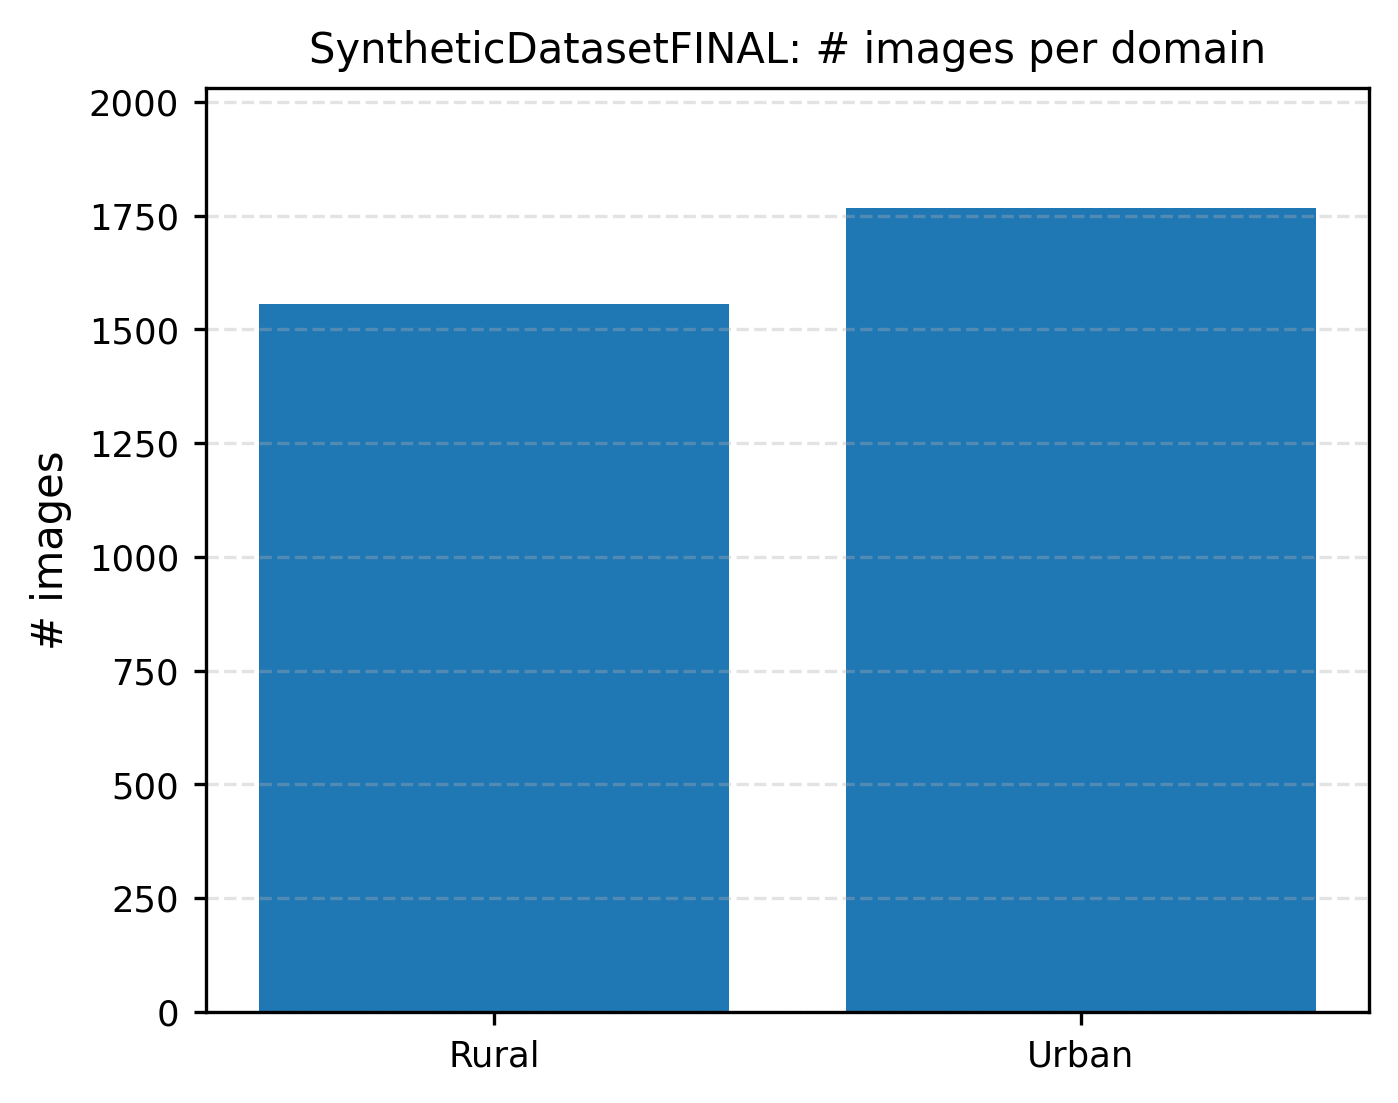

In [ ]:
from pathlib import Path
import matplotlib.pyplot as plt

# Count images per domain for SyntheticDatasetFINAL
# Reuses SYNTHETIC_DATASET_DIR if already set; otherwise sets it to the expected default.
try:
    SYNTHETIC_DATASET_DIR
except NameError:
    SYNTHETIC_DATASET_DIR = "/data/inr/llm/DIFF_CD/Diffusor/SyntheticDatasetFINAL/Train/Train"

def _count_domain_images(domain_root: Path) -> int:
    """Count image files for a domain (Rural/Urban)."""
    candidates = [
        domain_root / "images_png",
        domain_root / "images",
        domain_root / "imgs",
        domain_root / "img",
    ]
    exts = {".png", ".jpg", ".jpeg", ".tif", ".tiff"}

    for d in candidates:
        if d.exists():
            return sum(1 for p in d.iterdir() if p.is_file() and p.suffix.lower() in exts)

    # Fallback: search recursively but avoid masks folders
    count = 0
    for p in domain_root.rglob("*"):
        if not p.is_file():
            continue
        if p.suffix.lower() not in exts:
            continue
        parts = {s.lower() for s in p.parts}
        if "masks" in parts or "masks_png" in parts or "mask" in parts:
            continue
        count += 1
    return count

syn_base = Path(SYNTHETIC_DATASET_DIR)
syn_rural_root = syn_base / "Rural"
syn_urban_root = syn_base / "Urban"

syn_rural_n = _count_domain_images(syn_rural_root)
syn_urban_n = _count_domain_images(syn_urban_root)

print("SyntheticDatasetFINAL image counts")
print("- Rural:", syn_rural_n)
print("- Urban:", syn_urban_n)

plt.figure(figsize=(5, 4))
plt.bar(["Rural", "Urban"], [syn_rural_n, syn_urban_n])
plt.title("SyntheticDatasetFINAL: # images per domain")
plt.ylabel("# images")
plt.ylim(0, max(syn_rural_n, syn_urban_n) * 1.15 if max(syn_rural_n, syn_urban_n) > 0 else 1)
plt.grid(axis="y", linestyle="--", alpha=0.35)
plt.show()

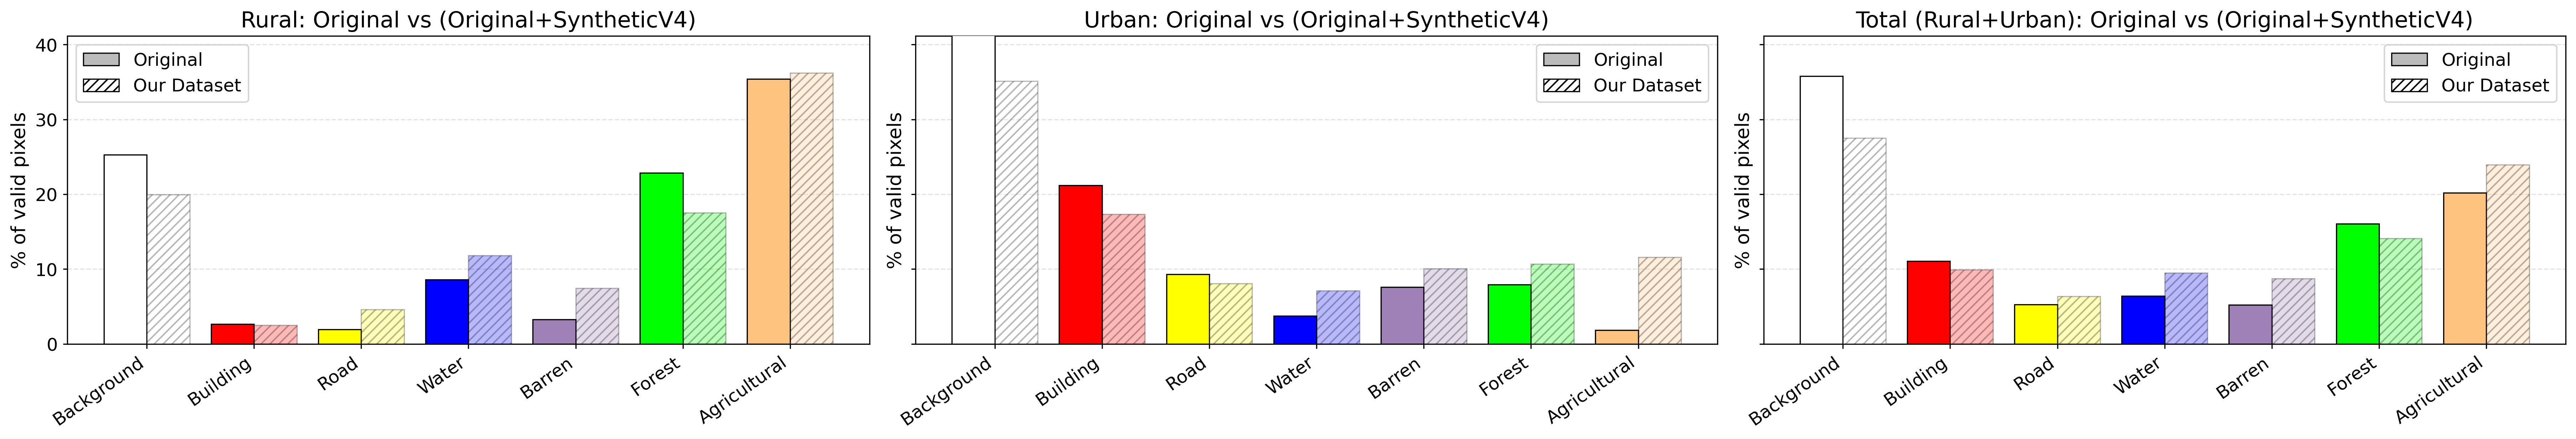

In [ ]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# This cell compares Original vs (Original + SyntheticV4) class percentages for:
#  - Rural
#  - Urban
#  - Total (Rural + Urban)
# Reuses: DATASET_DIR, SYNTHETIC_DATASET_DIR, COLORS, and compute_domain_percentages_from_mask_dirs() from prior cells.

orig_base = Path(DATASET_DIR)
syn_base = Path(SYNTHETIC_DATASET_DIR)

orig_rural_dir = orig_base / "Rural" / "masks_png"
orig_urban_dir = orig_base / "Urban" / "masks_png"
syn_rural_dir = syn_base / "Rural" / "masks_png"
syn_urban_dir = syn_base / "Urban" / "masks_png"

# Rural: original vs (original+synthetic)
orig_rural_pct, _, rural_conv_o, _ = compute_domain_percentages_from_mask_dirs([orig_rural_dir])
combo_rural_pct, _, rural_conv_c, _ = compute_domain_percentages_from_mask_dirs([orig_rural_dir, syn_rural_dir])

# Urban: original vs (original+synthetic)
orig_urban_pct, _, urban_conv_o, _ = compute_domain_percentages_from_mask_dirs([orig_urban_dir])
combo_urban_pct, _, urban_conv_c, _ = compute_domain_percentages_from_mask_dirs([orig_urban_dir, syn_urban_dir])

# Total (Rural+Urban): original vs (original+synthetic)
orig_total_pct, _, total_conv_o, _ = compute_domain_percentages_from_mask_dirs([orig_rural_dir, orig_urban_dir])
combo_total_pct, _, total_conv_c, _ = compute_domain_percentages_from_mask_dirs(
    [orig_rural_dir, orig_urban_dir, syn_rural_dir, syn_urban_dir]
 )

# Optional sanity checks: conventions should match
if rural_conv_o != rural_conv_c:
    print(f"Warning: Rural convention differs (orig={rural_conv_o}, combined={rural_conv_c})")
if urban_conv_o != urban_conv_c:
    print(f"Warning: Urban convention differs (orig={urban_conv_o}, combined={urban_conv_c})")
if total_conv_o != total_conv_c:
    print(f"Warning: Total convention differs (orig={total_conv_o}, combined={total_conv_c})")

# Use total ordering as canonical (covers both domains)
class_names = list(orig_total_pct.keys())
bar_colors = [np.array(COLORS.get(c, (160, 160, 160))) / 255.0 for c in class_names]
x = np.arange(len(class_names))
w = 0.40

# Font sizing (bigger + consistent)
TITLE_FZ = 15
LABEL_FZ = 13
TICK_FZ = 12
LEGEND_FZ = 12

# Styling to improve differentiability between the two datasets
ORIG_ALPHA = 1.0
OURS_ALPHA = 0.28
OURS_HATCH = "////"
EDGE = "black"
LW = 0.8

# Use a legend that encodes STYLE (solid vs hatched), not class color
legend_handles = [
    mpatches.Patch(facecolor="#bbbbbb", edgecolor=EDGE, linewidth=LW, label="Original"),
    mpatches.Patch(facecolor="#ffffff", edgecolor=EDGE, linewidth=LW, hatch=OURS_HATCH, label="Our Dataset"),
]

fig, axes = plt.subplots(1, 3, figsize=(24, 4), sharey=True, constrained_layout=True)

def _plot_compare(ax, title: str, orig_pct: dict, combo_pct: dict) -> None:
    orig_vals = [orig_pct.get(c, 0.0) for c in class_names]
    combo_vals = [combo_pct.get(c, 0.0) for c in class_names]

    ax.bar(
        x - w/2, orig_vals, width=w, color=bar_colors,
        edgecolor=EDGE, linewidth=LW, alpha=ORIG_ALPHA, zorder=3,
     )
    ax.bar(
        x + w/2, combo_vals, width=w, color=bar_colors,
        edgecolor=EDGE, linewidth=LW, alpha=OURS_ALPHA, hatch=OURS_HATCH, zorder=3,
     )

    ax.set_title(title, fontsize=TITLE_FZ)
    ax.set_xticks(x)
    ax.set_xticklabels(class_names, rotation=35, ha="right", fontsize=TICK_FZ)
    ax.tick_params(axis="y", labelsize=TICK_FZ)
    ax.set_ylim(0, max(max(orig_vals), max(combo_vals)) * 1.15 if max(max(orig_vals), max(combo_vals)) > 0 else 1)
    ax.grid(axis="y", linestyle="--", alpha=0.35, zorder=0)
    ax.set_axisbelow(True)
    ax.legend(handles=legend_handles, frameon=True, fontsize=LEGEND_FZ)

_plot_compare(axes[0], "Rural: Original vs (Original+SyntheticV4)", orig_rural_pct, combo_rural_pct)
axes[0].set_ylabel("% of valid pixels", fontsize=LABEL_FZ)

_plot_compare(axes[1], "Urban: Original vs (Original+SyntheticV4)", orig_urban_pct, combo_urban_pct)
axes[1].set_ylabel("% of valid pixels", fontsize=LABEL_FZ)

_plot_compare(axes[2], "Total (Rural+Urban): Original vs (Original+SyntheticV4)", orig_total_pct, combo_total_pct)
axes[2].set_ylabel("% of valid pixels", fontsize=LABEL_FZ)

plt.show()

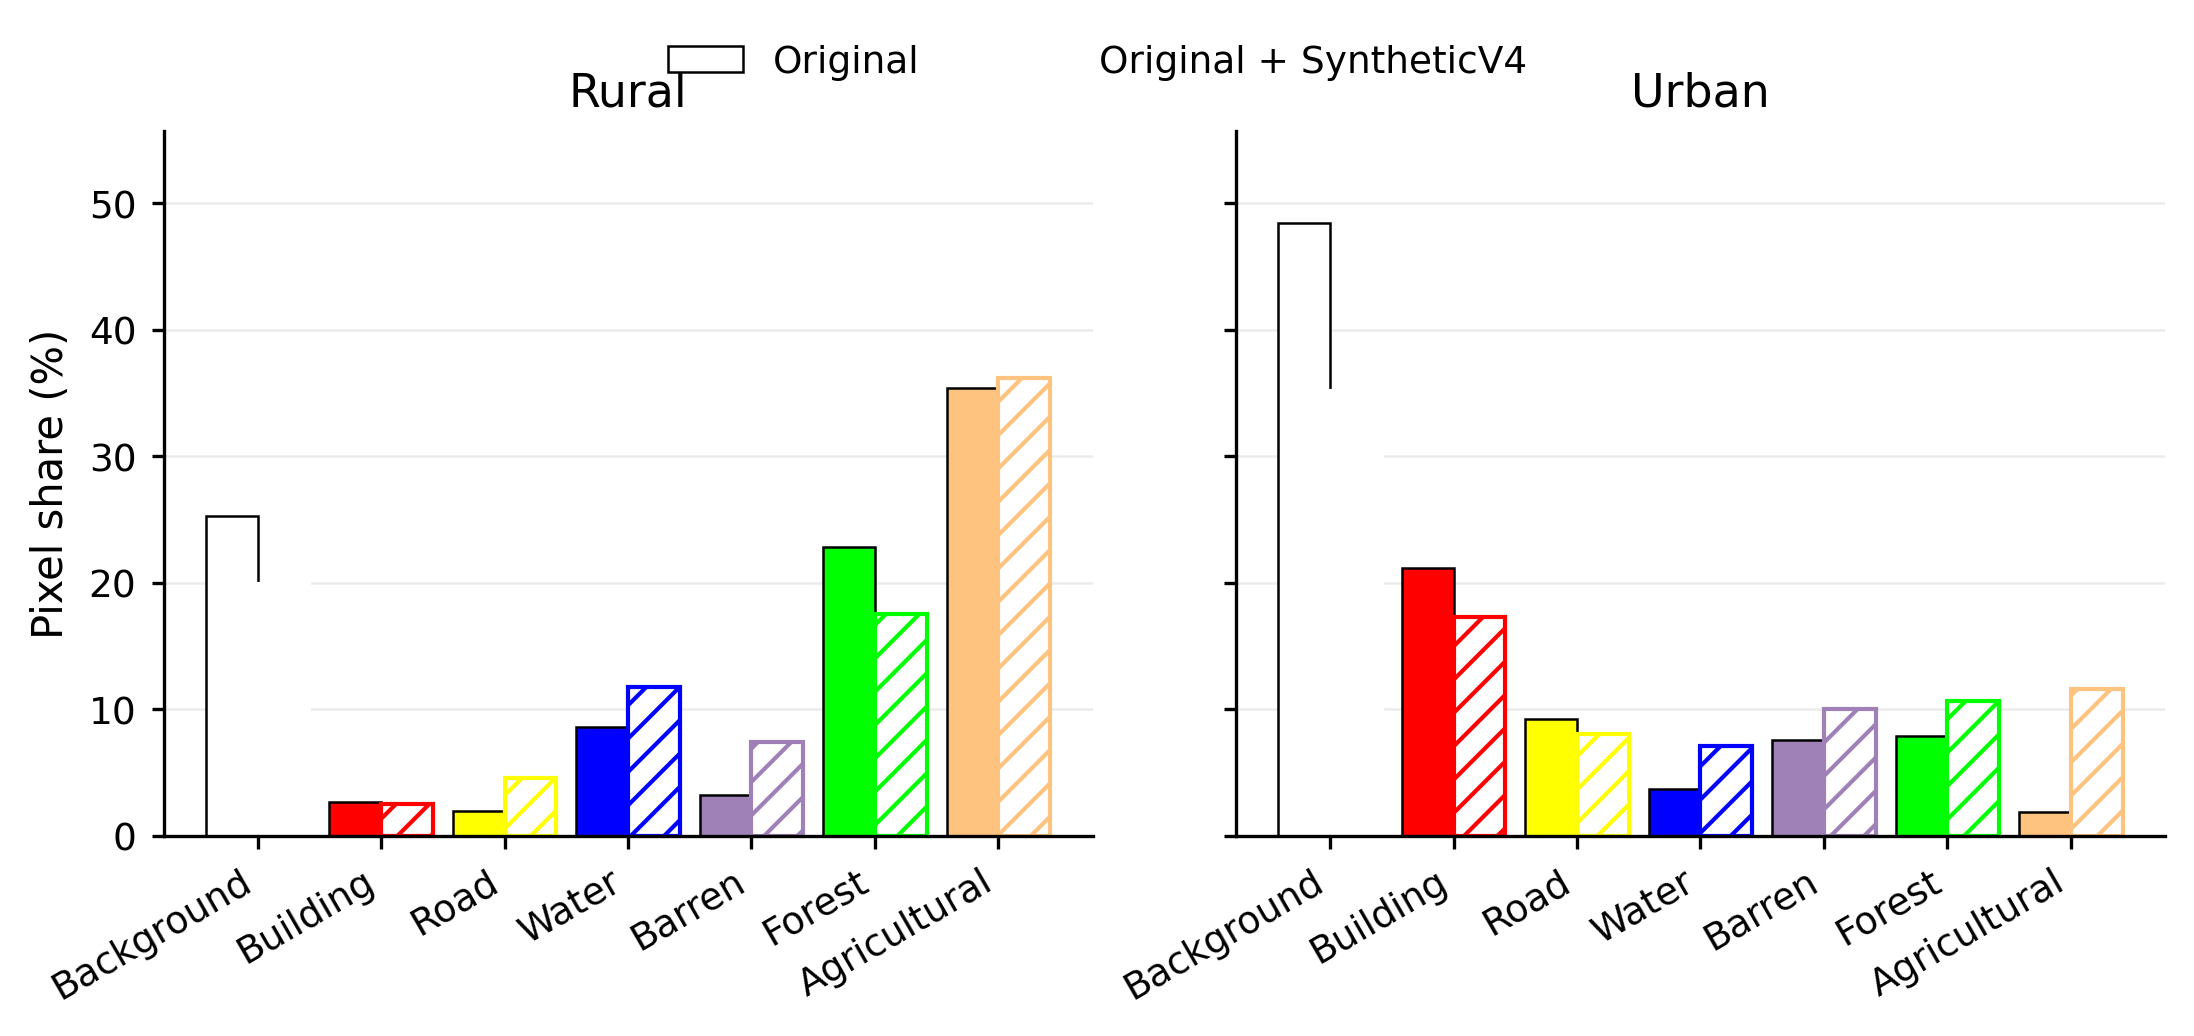

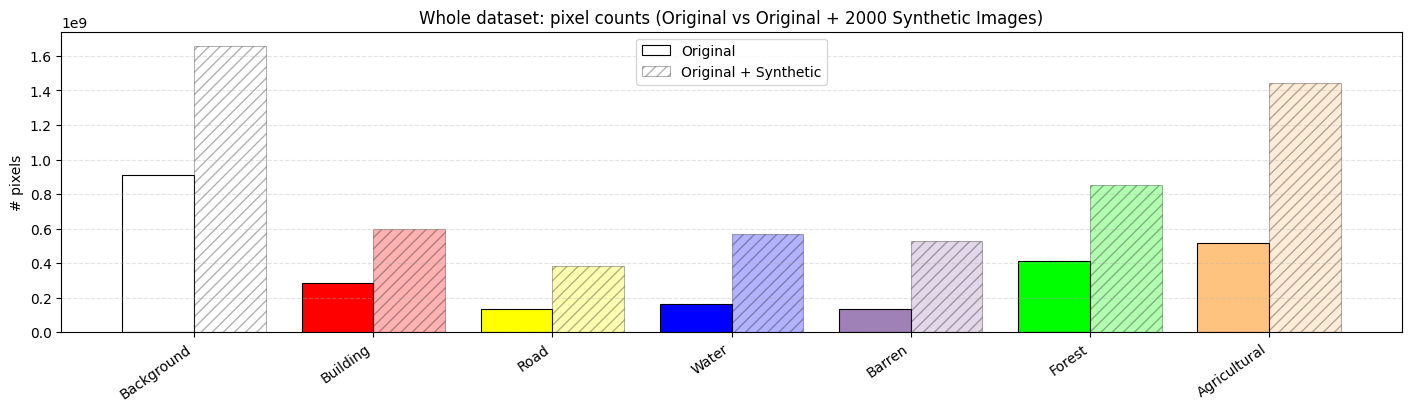

In [ ]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# Whole-dataset comparison (no domain split):
# Raw pixel counts per class for (Original) vs (Original + Synthetic).
# Reuses: DATASET_DIR, SYNTHETIC_DATASET_DIR, COLORS, compute_domain_percentages_from_mask_dirs() from prior cells.

orig_base = Path(DATASET_DIR)
syn_base = Path(SYNTHETIC_DATASET_DIR)

orig_rural_dir = orig_base / "Rural" / "masks_png"
orig_urban_dir = orig_base / "Urban" / "masks_png"
syn_rural_dir = syn_base / "Rural" / "masks_png"
syn_urban_dir = syn_base / "Urban" / "masks_png"

# Aggregate counts across Rural+Urban for original
_, orig_counts, conv_orig, _ = compute_domain_percentages_from_mask_dirs([orig_rural_dir, orig_urban_dir])

# Aggregate counts across Rural+Urban for (original + synthetic)
_, combo_counts, conv_combo, _ = compute_domain_percentages_from_mask_dirs(
    [orig_rural_dir, orig_urban_dir, syn_rural_dir, syn_urban_dir]
 )

if conv_orig != conv_combo:
    print(f"Warning: label convention differs (orig={conv_orig}, combined={conv_combo})")

class_names = list(orig_counts.keys())
bar_colors = [np.array(COLORS.get(c, (160, 160, 160))) / 255.0 for c in class_names]

x = np.arange(len(class_names))
w = 0.40

orig_vals = [orig_counts[c] for c in class_names]
combo_vals = [combo_counts.get(c, 0) for c in class_names]

plt.figure(figsize=(14, 4), constrained_layout=True)

# Original: solid filled bars
plt.bar(
    x - w/2,
    orig_vals,
    width=w,
    color=bar_colors,
    edgecolor="black",
    linewidth=0.8,
    label="Original",
)

# Original + Synthetic: hatched overlay for strong distinguishability
plt.bar(
    x + w/2,
    combo_vals,
    width=w,
    color=bar_colors,
    edgecolor="black",
    linewidth=0.8,
    alpha=0.30,
    hatch="///",
    label="Original + Synthetic",
)

plt.xticks(x, class_names, rotation=35, ha="right")
plt.ylabel("# pixels")
plt.title("Whole dataset: pixel counts (Original vs Original + 2000 Synthetic Images)")
plt.grid(axis="y", linestyle="--", alpha=0.35)
plt.legend()
plt.show()